In [1]:
from extract_desserts import *
from  pattern.text.en import singularize
from nltk import FreqDist

In [6]:
#load the raw data
# lets use the default value that only loads 250 recipes,
# instead of 1 million
raw_data = get_raw_data()
raw_ingredients = get_raw_ingredients()

Loading file  ../data/sample_layer1.json
Loading ingredient file: ../data/sample_det_ingrs.json


In [8]:
print('N recipes: ',
      len(raw_data),
      '\t N list of ingredients ', 
      len(raw_ingredients))


N recipes:  20000 	 N list of ingredients  20000


In [9]:
desserts, dessert_ings = find_desserts(raw_data, 
                                       raw_ingredients)


In [10]:
total_recipes = len(raw_data)
dessert_recipes = len(desserts)
dessert_ingredients = len(dessert_ings)
print('Will look at {} dessert recipes, out of {} (~{:1.1f}%)'.format(
                            dessert_recipes, total_recipes,
                            dessert_recipes/total_recipes*100))

Will look at 4793 dessert recipes, out of 20000 (~24.0%)


In [11]:
item = 123
print(dessert_ings[item]['valid'])
dessert_ings[item]['ingredients']

[True, True, True, True, True, True, True, True, True]


[{'text': 'butter'},
 {'text': 'sugar'},
 {'text': 'baking soda'},
 {'text': 'eggs'},
 {'text': 'flour'},
 {'text': 'cocoa'},
 {'text': 'soured milk'},
 {'text': 'raisins'},
 {'text': 'vanilla'}]

In [12]:
spices =['sugar','salt','water','baking soda','baking powder','flour', 'vegetable oil',
        'olive oil', 'cornstarch','nutmeg','white sugar','powdered sugar', 'brown sugar',
        'margarine','oil','shortening','kosher salt',"confectioners' sugar",'icing sugar',
        'canola oil','pepper' ,'low - fat milk','light corn syrup','cooking spray', 
         'corn syrup','vegetable shortening']

In [35]:
item=0
len(dessert_ings),len(dessert_ings[item]['ingredients'])

(4793, 5)

In [44]:
all_dingredients = []
count =0
for drecipe in dessert_ings:
    ings =[]
    for entry in drecipe['ingredients']:
        ings.append(entry['text'])
    all_dingredients.append(ings)
    count += 1
    if count%500==0:
        print(count, 'done')
#         break;

# print(all_dingredients)

500 done
1000 done
1500 done
2000 done
2500 done
3000 done
3500 done
4000 done
4500 done


In [48]:
all_dingredients[3400]

['oatmeal',
 'cottage cheese',
 'eggs',
 'milk',
 'cinnamon',
 'brown sugar',
 'raisins']

In [52]:
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', 
                    level=logging.INFO)



In [53]:
model = gensim.models.Word2Vec(
    all_dingredients,
    size=50,
    window=5,
    min_count=3,
    workers=10,
    iter=10
    )

2019-07-19 21:58:32,696 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-07-19 21:58:32,698 : INFO : collecting all words and their counts
2019-07-19 21:58:32,699 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-07-19 21:58:32,713 : INFO : collected 4078 word types from a corpus of 44027 raw words and 4793 sentences
2019-07-19 21:58:32,715 : INFO : Loading a fresh vocabulary
2019-07-19 21:58:32,719 : INFO : min_count=3 retains 1318 unique words (32% of original 4078, drops 2760)
2019-07-19 21:58:32,719 : INFO : min_count=3 leaves 40716 word corpus (92% of original 44027, drops 3311)
2019-07-19 21:58:32,725 : INFO : deleting the raw counts dictionary of 4078 items
2019-07-19 21:58:32,726 : INFO : sample=0.001 downsamples 59 most-common words
2019-07-19 21:58:32,727 : INFO : downsampling leaves estimated 25039 word corpus (61.5% of prior 40716)
2019-07-19 21:58:32,731 : INFO : estimated required memory for 1318 words a

2019-07-19 21:58:33,141 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-07-19 21:58:33,141 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-07-19 21:58:33,142 : INFO : EPOCH - 7 : training on 44027 raw words (25030 effective words) took 0.0s, 908138 effective words/s
2019-07-19 21:58:33,162 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-07-19 21:58:33,177 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-07-19 21:58:33,185 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-07-19 21:58:33,186 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-07-19 21:58:33,188 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-07-19 21:58:33,188 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-07-19 21:58:33,190 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-07-19 21:58:33,191 : INFO : worker thread f

In [55]:
w1='butter'
model.wv.most_similar(positive=w1, topn=4)

[('peanut butter', 0.9971922636032104),
 ('chocolate chips', 0.9969877004623413),
 ('pecans', 0.9954007863998413),
 ('bananas', 0.9950093030929565)]

In [78]:
w1='rum'
model.wv.most_similar(positive=['rum','banana'],
                      negative=['butter'],topn=10)

[('dry red wine', 0.9976661205291748),
 ('scallion', 0.9976271390914917),
 ('pine nuts', 0.9975374937057495),
 ('salt and black pepper', 0.9974648952484131),
 ('fresh chives', 0.997443675994873),
 ('fresh cilantro', 0.9973474740982056),
 ('red wine', 0.9972602128982544),
 ('fresh dill', 0.9972414374351501),
 ('turkey', 0.9971878528594971),
 ('leeks', 0.9971705079078674)]

In [64]:
model.wv.similarity('egg','bacon')

0.6568946138721347

In [15]:
# create bag of ingredients

all_ingredients = []

for recipe_ings in dessert_ings:
    n_ingredients = len(recipe_ings['valid'])
    for item, ingredient in enumerate(recipe_ings['ingredients']):
        if recipe_ings['valid'][item] ==True:
            ingred = ingredient['text'].lower()
#             ingred = singularize(ingred)
#             if ingred=='eggs':
#                 ingred='egg'
#             elif 'butter' in ingred:
#                 ingred = 'butter'
            
#             elif ingred == 'granulated sugar':
#                 ingred= 'sugar'
#             elif 'flour' in ingred:
#                 ingred = 'flour'
#             elif ingred == 'all - purpose flour' or ingred == 'cake flour':
#                 ingred = 'flour'
#             elif ingred == 'boiling water' or  ingred=='cold water':
#                 ingred = 'water'
#             elif ingred== 'light brown sugar' or ingred == 'dark brown sugar':
#                 ingred = 'sugar'
#             elif ingred == 'vanilla extract' or ingred == 'pure vanilla extract':
#                 ingred = 'vanilla'
#             elif ingred == 'fresh lemon juice':
#                 ingred = 'lemon juice'
            # find if ingredient belongs to a spice list
            an_ingredient, ingred = is_it_an_ingredient(ingred)
            if an_ingredient:
                # make it singular
                
                ingred = singularize(ingred)
                all_ingredients.append(ingred)
                
#             if ingred not in spices:
#                 all_ingredients.append(ingred)
            

In [14]:
import re

spice_list = ['sugar','salt','water','baking soda','baking powder','flour', 'oil',
         'cornstarch','sugar','margarine','shortening','pepper' ,'milk','light corn syrup','cooking spray', 
         'corn syrup', 'butter']

def is_it_an_ingredient(ingredient):
    for spice in spice_list:
        if re.search(spice, ingredient):
#             print( ingredient,' -> ingredient is a spice')
            return False, spice
#     print('Did not find ingredient in the list of spices')    
    return True, ingredient

    

In [16]:
ignore_singularize = ['nuts','molasses']

In [17]:
ingredient_set = set(all_ingredients)
print('with {} recipes, there are {} ingredients, and {} unique ingredients.'.format(
                dessert_recipes, len(all_ingredients), len(ingredient_set)))

with 4793 recipes, there are 23554 ingredients, and 2586 unique ingredients.


In [18]:
singularize('sour cream')

'sour cream'

In [19]:
fdist = FreqDist(all_ingredients)
print(fdist)

<FreqDist with 2586 samples and 23554 outcomes>


In [20]:
common = fdist.most_common(4200)

In [30]:
for c in common:
    if 'soy' in c[0]:
        print(c)
    

('soy sauce', 37)
('soy cream cheese', 2)
('soy yogurt', 2)
('dark soy sauce', 2)
('soy sour cream', 1)
('light soy sauce', 1)
('roasted soybean', 1)
('low sodium soy sauce', 1)


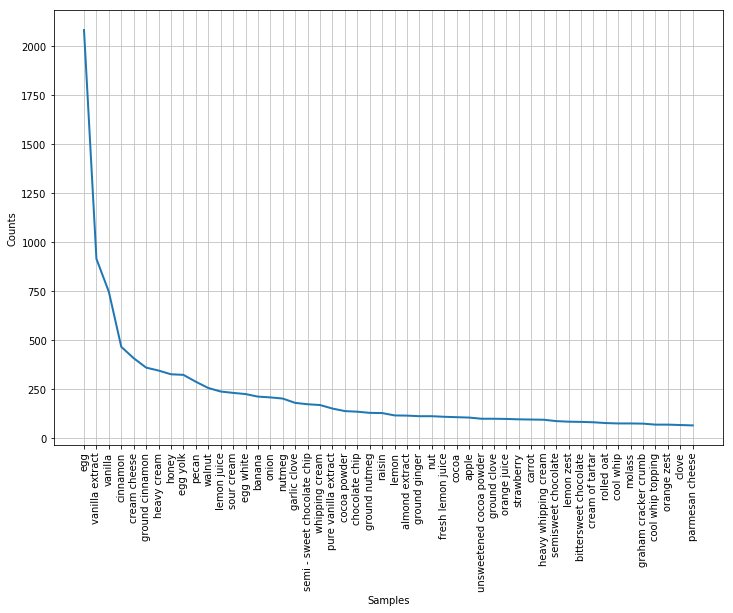

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 8))
# plt.ylim(0,120)
fdist.plot(50,cumulative=False)
# plt.ylim(0,30)
# plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
import string

from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
np.random.seed(23)

In [ ]:
stopwords_list  = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list +=

In [ ]:
stopwords_list[-20:]